# FTW Inference Notebook  


This notebook demonstrates **end-to-end inference** using segmentation models trained on the **[Fields of The World (FTW) dataset](https://fieldsofthe.world/)**.  

**FTW (Fields of The World)** is a comprehensive benchmark dataset designed to advance the development of machine learning models for **segmentation of agricultural field boundaries**. It aggregates and harmonizes data from multiple open sources into:  

- **1.6 million parcel boundaries**  
- **70,000+ samples**  
- **Spanning diverse agricultural landscapes across 4 continents and 24 countries**  

The dataset provides a standardized global benchmark to train and evaluate models for agricultural monitoring, on **field delineation** from satellite imagery.  

This notebook showcases how to:  
- Define a **Region of Interest (ROI)**  
- Extract **seasonal crop calendar information**  
- Query **Sentinel-2 imagery** from the Microsoft Planetary Computer  
- Download data in the **FTW format**  
- Run **inference with FTW CLI tools**  

---

## 1. Setup and Installation  

- Install **torchgeo**
- Install **ftw-tools**, which provides a CLI for inference with FTW models.   

In [1]:
!pip install --quiet torchgeo ftw-tools 2>/dev/null

In [2]:
import os
import urllib.request
import subprocess
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shapely.geometry
import fiona.transform
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime, timedelta
from pyproj import Transformer
import folium
from shapely.geometry import Point
from rasterio.transform import rowcol
import pystac_client
import planetary_computer
import geopandas as gpd

## 2. Defining the Region of Interest (ROI)  

The **Region of Interest (ROI)** specifies the geographic bounding box you want to run inference on.  

- Coordinates are defined in **EPSG:4326 (lat/lon)**.  
- A **Folium map** is generated to visualize the bounding box.  

```python
roi = {
    "topleft_coordinate": (lon, lat) # top-left
    "bottomright_coordinate": (lon, lat) # bottom-right
    "projection": "EPSG:4326"
}


In [3]:
roi = {
    "topleft_coordinate": (-83.602970, 39.886606),     # (lon, lat) top-left
    "bottomright_coordinate": (-83.463451, 39.815185), # (lon, lat) bottom-right
    "projection": "EPSG:4326"
}


In [4]:
def parse_coordinates(roi):
    topleft = roi["topleft_coordinate"]
    bottomright = roi["bottomright_coordinate"]
    proj = roi.get("projection", "EPSG:4326")

    if proj != "EPSG:4326":
        transformer = Transformer.from_crs(proj, "EPSG:4326", always_xy=True)
        tl_lon, tl_lat = transformer.transform(*topleft)
        br_lon, br_lat = transformer.transform(*bottomright)
    else:
        tl_lon, tl_lat = topleft
        br_lon, br_lat = bottomright

    center_lon = (tl_lon + br_lon) / 2
    center_lat = (tl_lat + br_lat) / 2

    return (center_lon, center_lat), (tl_lon, tl_lat), (br_lon, br_lat)

In [5]:
center, tl, br = parse_coordinates(roi)

# our coordinates have order lon, lat but folium expects lat, lon
m = folium.Map(location=(center[1], center[0]), zoom_start=12)

bbox = [
    (tl[1], tl[0]),
    (br[1], tl[0]),
    (br[1], br[0]),
    (tl[1], br[0]),
    (tl[1], tl[0])
]
folium.PolyLine(bbox, color="blue", weight=2.5, opacity=0.7).add_to(m)
folium.Marker((center[1], center[0])).add_to(m)

m

## 3. Extracting Crop Season Dates  

FTW relies on **crop calendars** to align imagery with key agricultural phases:  

- **SOS (Start of Season)** → defines planting or crop emergence  
- **EOS (End of Season)** → defines harvest  

These seasonal dates allow the notebook to identify relevant time windows for satellite imagery collection.  


In [6]:
def calculate_window_dates(sos_date, eos_date):
    """
    Calculate window dates based on SOS and EOS dates.
    """

    sos = datetime.strptime(sos_date, '%Y-%m-%d')
    eos = datetime.strptime(eos_date, '%Y-%m-%d')

    win_a_start = (sos - timedelta(days=15)).strftime('%Y-%m-%d')
    win_a_end = (sos + timedelta(days=15)).strftime('%Y-%m-%d')
    win_b_start = (eos - timedelta(days=30)).strftime('%Y-%m-%d')
    win_b_end = eos.strftime('%Y-%m-%d')

    return win_a_start, win_a_end, win_b_start, win_b_end

def get_date_from_day_of_year(day_of_year: int, year: int) -> str:
    if day_of_year < 1 or day_of_year > 366:
        raise ValueError("day_of_year must be between 1 and 366")
    base_date = datetime(year, 1, 1)
    result_date = base_date + timedelta(days=day_of_year - 1)
    if day_of_year == 366 and result_date.year != year:
        raise ValueError(f"{year} is not a leap year.")
    return result_date.strftime("%Y-%m-%d")

def get_dates_from_tifs(point: Point, start_season_tif_path: str, end_season_tif_path: str, year=2020, season_type='winter'):
    """
    Extract start and end crop calendar dates (day-of-year and date) from GeoTIFFs using rasterio.

    Args:
        point: shapely.geometry.Point
        start_season_tif_path: path to the start season GeoTIFF
        end_season_tif_path: path to the end season GeoTIFF
        year: crop calendar reference year

    Returns:
        (start_day, end_day, start_date_str, end_date_str)
    """
    with rasterio.open(start_season_tif_path) as start_src:
        row, col = rowcol(start_src.transform, point.x, point.y)
        start_day = start_src.read(1)[row, col]

    with rasterio.open(end_season_tif_path) as end_src:
        row, col = rowcol(end_src.transform, point.x, point.y)
        end_day = end_src.read(1)[row, col]

    # Handle crop calendars that span across years, like a season starting in September and ending in March
    end_year = year + 1 if end_day < start_day else year

    start_date = get_date_from_day_of_year(int(start_day), year)
    end_date = get_date_from_day_of_year(int(end_day), end_year)

    return start_date, end_date

def download_crop_calendars(crop_calendar_files, crop_calendar_dir="./"):
    """Download crop calendar files into ./data if they don't exist."""
    os.makedirs(crop_calendar_dir, exist_ok=True)
    base_url = "https://github.com/fieldsoftheworld/ftw-qgis-plugin/raw/main/resources/global_crop_calendars/"

    for season, files in crop_calendar_files.items():
        for file_type, filename in files.items():
            local_path = os.path.join(crop_calendar_dir, filename)
            if not os.path.exists(local_path):
                try:
                    urllib.request.urlretrieve(base_url + filename, local_path)
                except Exception as e:
                    print(f"Failed to download {filename}: {str(e)}")
                    return False
    return True


In [7]:
crop_calendar_files = {
    "summer": {
        "start": "sc_sos_3x3_v2.tiff",
        "end": "sc_eos_3x3_v2.tiff"
    },
    "winter": {
        "start": "wc_sos_3x3_v2.tiff",
        "end": "wc_eos_3x3_v2.tiff"
    }
}

download_crop_calendars(crop_calendar_files)

True

In [19]:
field_center_point = Point(center[0], center[1])
agricultural_year = 2024
season = "summer"
start_tif = crop_calendar_files[season]["start"]
end_tif = crop_calendar_files[season]["end"]

start_date, end_date = get_dates_from_tifs(
                point=field_center_point,
                start_season_tif_path=start_tif,
                end_season_tif_path=end_tif,
                year=agricultural_year,
                season_type=season
            )

print(f"Season start date: {start_date}")
print(f"Season end date: {end_date}")

Season start date: 2024-04-16
Season end date: 2024-11-10


In [20]:
win_a_start, win_a_end, win_b_start, win_b_end = calculate_window_dates(start_date, end_date)

print(f"Window A start date: {win_a_start}")
print(f"Window A end date: {win_a_end}")
print(f"Window B start date: {win_b_start}")
print(f"Window B end date: {win_b_end}")

Window A start date: 2024-04-01
Window A end date: 2024-05-01
Window B start date: 2024-10-11
Window B end date: 2024-11-10


In [21]:
MSPC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
COLLECTION_ID = "sentinel-2-l2a"

def get_best_image_ids(top_left, bottom_right, win_a_start, win_a_end, win_b_start, win_b_end, max_cloud_cover=20, s2_tile_id=None):
    catalog = pystac_client.Client.open(
        MSPC_URL,
        modifier=planetary_computer.sign_inplace,
    )

    min_lon, min_lat = top_left[0], bottom_right[1]
    max_lon, max_lat = bottom_right[0], top_left[1]
    bbox_geom = {
        "type": "Polygon",
        "coordinates": [[
            [min_lon, min_lat],
            [min_lon, max_lat],
            [max_lon, max_lat],
            [max_lon, min_lat],
            [min_lon, min_lat],
        ]]
    }

    def find_best_image(start_date, end_date, cloud_threshold,s2_tile_id=None):
        time_range = f"{start_date}/{end_date}"
        print(f"Searching for images between {start_date} and {end_date} with cloud cover < {cloud_threshold}%")

        if s2_tile_id:
            # search for a specific S2 tile ID
            search = catalog.search(
                collections=[COLLECTION_ID],
                datetime=time_range,
                query={
                  "eo:cloud_cover": {"lt": cloud_threshold},
                  "s2:mgrs_tile": {"eq": s2_tile_id},
                  "s2:nodata_pixel_percentage": {"lt": 10}
                },
            )
        else:
            # search using the bounding box
            search = catalog.search(
              collections=[COLLECTION_ID],
              intersects=bbox_geom,
              datetime=time_range,
              query={"eo:cloud_cover": {"lt": cloud_threshold}},
            )

        items = search.item_collection()
        if len(items) == 0:
            print(f"No images found with cloud cover < {cloud_threshold}%")
            return None

        best_item = min(items, key=lambda item: item.properties.get("eo:cloud_cover", 100))
        cloud_cover = best_item.properties.get("eo:cloud_cover", 100)
        print(f"Found image from {best_item.datetime.date()} with {cloud_cover}% cloud coverage")
        return best_item.id

    cloud_thresholds = [max_cloud_cover, 50, 70, 100]
    win_a_id = None
    win_b_id = None

    for threshold in cloud_thresholds:
        if win_a_id is None:
            win_a_id = find_best_image(win_a_start, win_a_end, threshold, s2_tile_id)
        if win_b_id is None:
            win_b_id = find_best_image(win_b_start, win_b_end, threshold, s2_tile_id)
        if win_a_id is not None and win_b_id is not None:
            break

    if win_a_id is None:
        raise ValueError(f"Could not find suitable images for window A ({win_a_start} to {win_a_end}) even with 100% cloud cover")
    if win_b_id is None:
        raise ValueError(f"Could not find suitable images for window B ({win_b_start} to {win_b_end}) even with 100% cloud cover")

    return win_a_id, win_b_id, [min_lon, min_lat, max_lon, max_lat]

In [22]:
win_a_id, win_b_id, bbox_list = get_best_image_ids(tl, br, win_a_start, win_a_end, win_b_start, win_b_end, s2_tile_id="15TVH")

Searching for images between 2024-04-01 and 2024-05-01 with cloud cover < 20%
Found image from 2024-04-15 with 0.000447% cloud coverage
Searching for images between 2024-10-11 and 2024-11-10 with cloud cover < 20%
Found image from 2024-10-27 with 4.811382% cloud coverage


In [23]:
print(f"Window A ID: {win_a_id}")
print(f"Window B ID: {win_b_id}")

Window A ID: S2B_MSIL2A_20240415T165849_R069_T15TVH_20240415T230914
Window B ID: S2A_MSIL2A_20241027T170421_R069_T15TVH_20241027T204452


## 4. Download FTW Input Ready Image

In [24]:
ftw_cmd = "ftw"
filename = "sample_ftw_input.tif"
bbox_str = ",".join(map(str, bbox_list))

cmd = [
    ftw_cmd, "inference", "download",
    "--win_a", win_a_id,
    "--win_b", win_b_id,
    "--out", filename,
    "--bbox", bbox_str,
    "--overwrite"
]

print(cmd)

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stdout)
    print("Download Complete")
except subprocess.CalledProcessError as e:
    print("Error:", e.stderr)


['ftw', 'inference', 'download', '--win_a', 'S2B_MSIL2A_20240415T165849_R069_T15TVH_20240415T230914', '--win_b', 'S2A_MSIL2A_20241027T170421_R069_T15TVH_20241027T204452', '--out', 'sample_ftw_input.tif', '--bbox', '-83.60297,39.815185,-83.463451,39.886606', '--overwrite']
Processing version of imagery differs. Exiting.

Download Complete


## 5. Run Inference

In [14]:
# download the model checkpoint --3classes
url = "https://github.com/fieldsoftheworld/ftw-baselines/releases/download/v1/3_Class_FULL_FTW_Pretrained.ckpt"
model_filename = "3_Class_FULL_FTW_Pretrained.ckpt"
urllib.request.urlretrieve(url, model_filename)

('3_Class_FULL_FTW_Pretrained.ckpt',
 <http.client.HTTPMessage at 0x7815a0fae1b0>)

In [15]:
filename = "sample_ftw_input.tif"
cmd = [
    ftw_cmd, "inference", "run", filename,
    "-f", "-o", "sample_ftw_output.tif",
    "--gpu", "0", "-m", "3_Class_FULL_FTW_Pretrained.ckpt"
]

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error:", e.stderr)

Neither GPU nor MPS mode is enabled, defaulting to CPU.
Input image size: 2048x2048 pixels (HxW)
Patch size: 1024
Padding: 64
Using custom trainer
"backbone":        efficientnet-b3
"class_weights":   [0.04, 0.08, 0.88]
"freeze_backbone": False
"freeze_decoder":  False
"ignore_index":    3
"in_channels":     8
"loss":            ce
"lr":              0.001
"model":           unet
"model_kwargs":    {}
"num_classes":     3
"num_filters":     64
"patch_weights":   False
"patience":        100
Finished inference and saved output to sample_ftw_output.tif in 307.67s



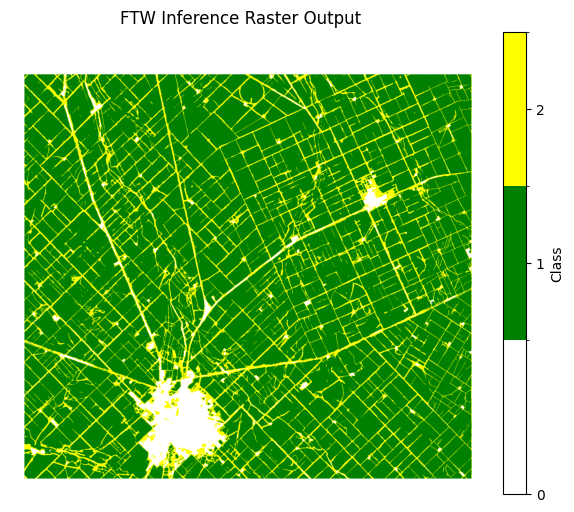

In [16]:
import matplotlib.colors as mcolors

raster_file = "sample_ftw_output.tif"

cmap = mcolors.ListedColormap(["white",           # (1, 1, 1, 0), # RGBA for transparent
                               'green',
                               'yellow'])

bounds = [0, 0.5, 1.5, 2.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

with rasterio.open(raster_file) as src:
    data = src.read(1)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(data, cmap=cmap, norm=norm)
    plt.colorbar(im, ticks=[0, 1, 2], label="Class")
    plt.title("FTW Inference Raster Output")
    plt.axis("off")
    plt.show()


## 6. Polygonize Output

In [17]:
in_raster = "sample_ftw_output.tif"
out_vector = "sample_ftw_output.geojson"

cmd = [
    ftw_cmd, "inference", "polygonize", in_raster,
    "-o", out_vector,
    "-f",
    "--simplify", "20",
    "--min_size", "0"
]

try:
    result = subprocess.run(cmd, check=True, capture_output=True, text=True)
    print("Polygonization complete:", out_vector)
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error:", e.stderr)


Polygonization complete: sample_ftw_output.geojson
Polygonizing input file: sample_ftw_output.tif
Finished polygonizing output at sample_ftw_output.geojson in 4.04s



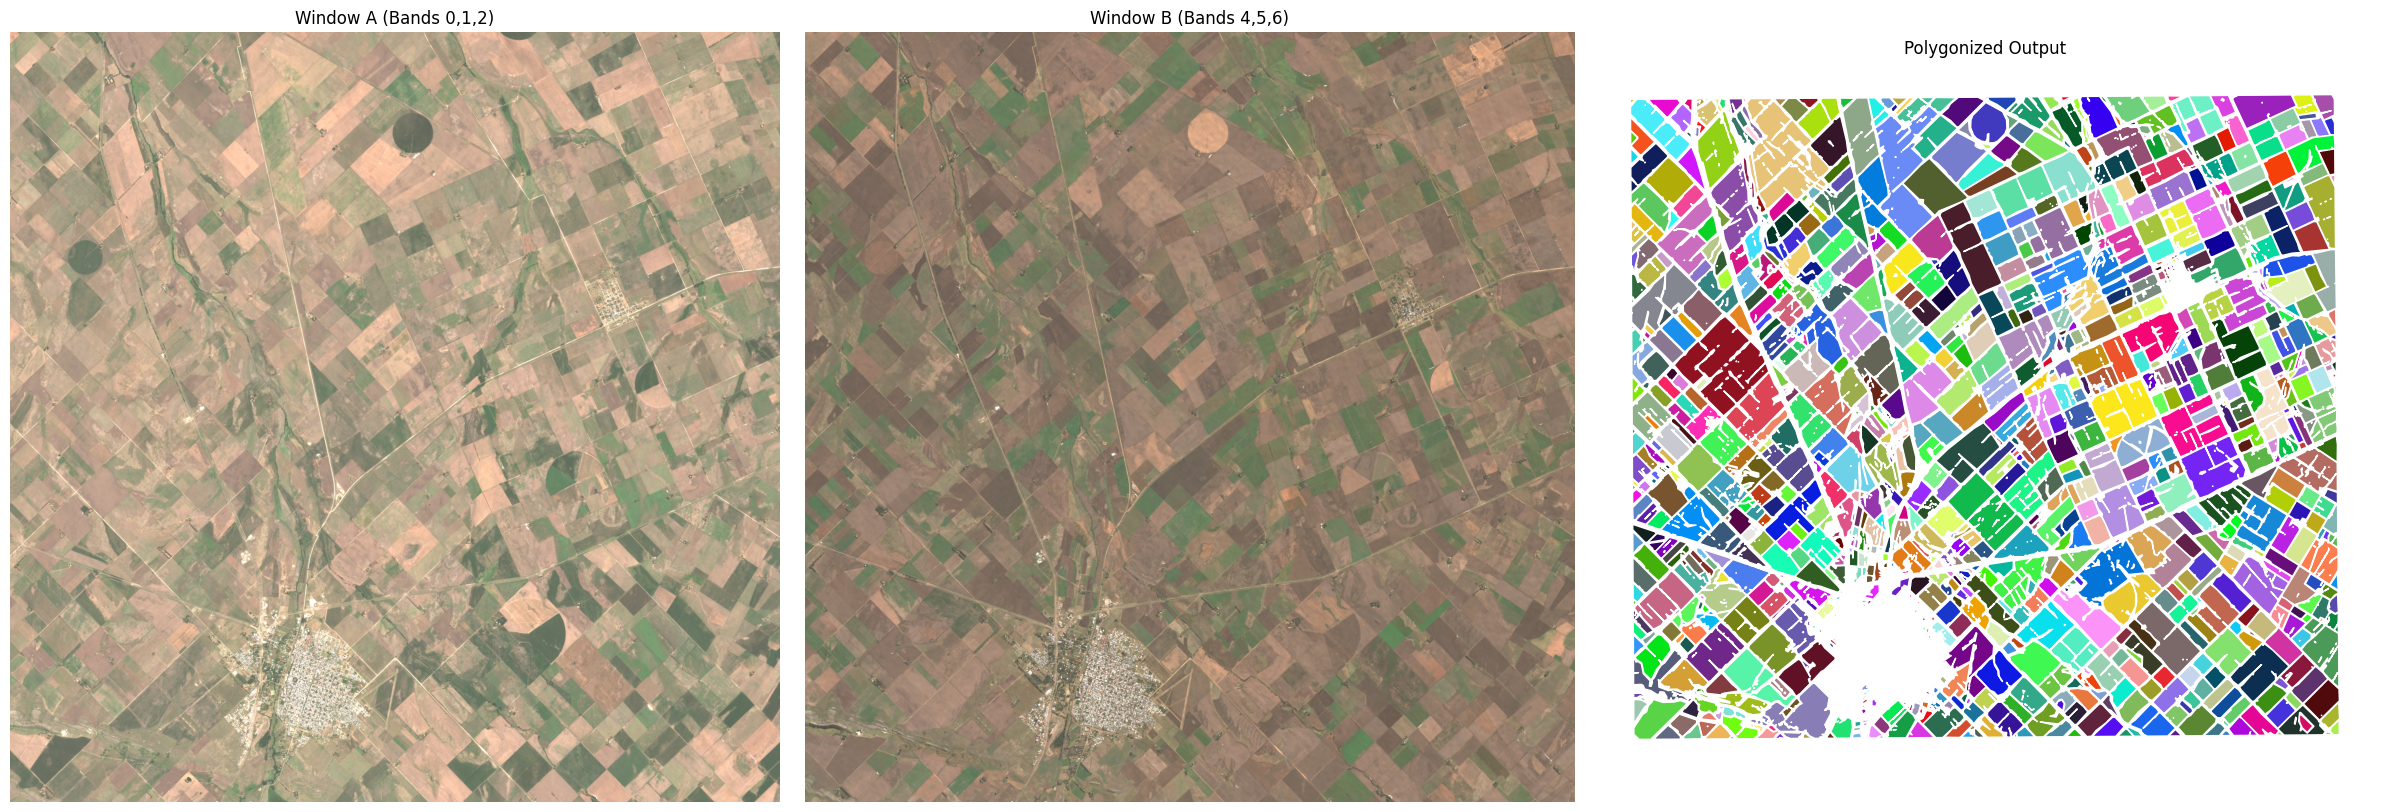

In [18]:
def visualize_ftw_output(window_a_b_file, raster_output_file, vector_output_file):

    with rasterio.open(window_a_b_file) as src:
        window_a = src.read([1, 2, 3])
        window_a = window_a.transpose(1, 2, 0)
        window_a = window_a / 3000

    with rasterio.open(window_a_b_file) as src:
        window_b = src.read([5, 6, 7])
        window_b = window_b.transpose(1, 2, 0)
        window_b = window_b / 3000

    with rasterio.open(raster_output_file) as src:
        raster_out = src.read(1)

    gdf = gpd.read_file(vector_output_file)
    num_polygons = len(gdf)
    colors = np.random.rand(num_polygons, 3)

    fig, axs = plt.subplots(1, 3, figsize=(24, 8))

    axs[0].imshow(np.clip(window_a, 0, 1))
    axs[0].set_title("Window A (Bands 0,1,2)")

    axs[1].imshow(np.clip(window_b, 0, 1))
    axs[1].set_title("Window B (Bands 4,5,6)")

    gdf.plot(ax=axs[2], color=colors, edgecolor="white")
    axs[2].set_title("Polygonized Output")

    for ax in axs:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

visualize_ftw_output(
    window_a_b_file="sample_ftw_input.tif",
    raster_output_file="sample_ftw_output.tif",
    vector_output_file="sample_ftw_output.geojson"
)
